In [2]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

In [3]:
# 策略继承CtaTemplate
class MultiFrameWVADStrategy(CtaTemplate):
    className = 'MultiFrameWVADStrategy'
    author = 'howers'
    # 策略参数
    amWindow = 20
    wvadPeriod = 24; Ma6wvadPeriod = 6
    Ma24wvadPeriod = 24
    trailingPct = 0.04
    lot = 1
    # 策略变量
    transactionPrice = {} # 记录成交价格
    intraTradeHighDict = {}; intraTradeLowDict = {}
    WVAD = {}
    # 参数列表，保存了参数的名称
    paramList = [
                 'amWindow',
                 'wvadPeriod', 'Ma6wvadPeriod',
                 'Ma24wvadPeriod','trailingPct'
                ]    
    # 变量列表，保存了变量的名称
    varList = ['transactionPrice'
               'intraTradeHighDict', 'intraTradeLowDict'
               'WVAD'
              ]  
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s:0 for s in self.symbolList}
        self.intraTradeLowDict = {s:999999 for s in self.symbolList}
        self.WVAD = {s:0 for s in self.symbolList}
        self.putEvent()
    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        # 洗价器（止盈止损）
        if self.posDict[symbol+'_LONG'] == 0 and self.posDict[symbol+'_SHORT'] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999
        # 持有多头仓位
        elif self.posDict[symbol+'_LONG'] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPct)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[symbol+'_LONG'])
#         # 持有空头仓位
        elif self.posDict[symbol+'_SHORT'] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPct)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[symbol+'_SHORT'])
        self.putEvent()
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m")
        if not am60.inited:
            return
        # 计算均线并判断趋势
        wvad = ta.SUM(((am60.close-am60.close[-1])/(am60.high-am60.low))*am60.volume,self.wvadPeriod)
        ma6wvad=ta.MA(wvad,self.Ma6wvadPeriod)
        ma24wvad=ta.MA(wvad,self.Ma24wvadPeriod)
        
            
        Signal=self.WVAD[symbol]   
        if ma6wvad[-1]>ma24wvad[-1] and (self.posDict[symbol+'_LONG']==0):
            if self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol,bar.close*1.02, self.lot)
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.1, self.posDict[symbol+'_SHORT'])
                self.buy(symbol,bar.close*1.1, self.lot)
        elif ma6wvad[-1]<ma24wvad[-1] and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol,bar.close*0.9, self.lot)
            elif self.posDict[symbol+'_LONG']>0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.short(symbol,bar.close*0.98, self.lot)
        self.putEvent()
   
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做交易信息记录的策略，可以忽略onTrade
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [4]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180901 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181123 12:00') # 设置回测用的数据终止日期
    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金
    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiFrameWVADStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7485CC7B8>, <__main__.MultiFrameWVADStrategy object at 0x000001C7485ADE10>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7485CC840>, <__main__.MultiFrameWVADStrategy object at 0x000001C7485ADE10>)
2018-12-08 23:05:44.001464	开始回测
2018-12-08 23:05:44.001464	策略初始化
2018-12-08 23:05:44.002465	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:05:44.594859	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:05:44.597874	载入完成，数据量：12000
2018-12-08 23:05:44.597874	策略初始化完成
2018-12-08 23:05:44.597874	策略启动完成
2018-12-08 23:05:44.597874	开始回放回测数据,回测范围:[20180901 12:00,20181123 12:00)
2018-12-08 23:05:44.609869	载入历史数据。数据范围:[20180901 12:00,20181123 12:00)
2018-12-08 23:05:49.486132	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:05:49.514139	载入完成，数

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-22 08:00:00,空,,,0.0,,开仓,197,,4661.08,0.0,None,,,197,2018-11-22 08:00:00,1,197,BTCUSDT:binance,197
2018-11-22 13:00:00,多,,,0.0,,平仓,198,,4613.65,0.0,None,,,198,2018-11-22 13:00:00,1,198,BTCUSDT:binance,198
2018-11-22 13:00:00,多,,,0.0,,开仓,199,,4613.65,0.0,None,,,199,2018-11-22 13:00:00,1,199,BTCUSDT:binance,199
2018-11-22 21:00:00,空,,,0.0,,平仓,200,,4524.00,0.0,None,,,200,2018-11-22 21:00:00,1,200,BTCUSDT:binance,200
2018-11-22 21:00:00,空,,,0.0,,开仓,201,,4524.00,0.0,None,,,201,2018-11-22 21:00:00,1,201,BTCUSDT:binance,201


2018-12-08 23:06:03.760815	计算按日统计结果
2018-12-08 23:06:03.794837	------------------------------
2018-12-08 23:06:03.795838	首个交易日：	2018-09-01 00:00:00
2018-12-08 23:06:03.795838	最后交易日：	2018-11-23 00:00:00
2018-12-08 23:06:03.795838	总交易日：	84
2018-12-08 23:06:03.795838	盈利交易日	41
2018-12-08 23:06:03.795838	亏损交易日：	42
2018-12-08 23:06:03.795838	起始资金：	1000000
2018-12-08 23:06:03.795838	结束资金：	1,002,068.02
2018-12-08 23:06:03.795838	总收益率：	0.21%
2018-12-08 23:06:03.795838	年化收益：	0.59%
2018-12-08 23:06:03.795838	总盈亏：	2,068.02
2018-12-08 23:06:03.795838	最大回撤: 	-926.68
2018-12-08 23:06:03.795838	百分比最大回撤: -0.09%
2018-12-08 23:06:03.795838	总手续费：	632.78
2018-12-08 23:06:03.796839	总滑点：	0.4
2018-12-08 23:06:03.796839	总成交金额：	1,265,556.11
2018-12-08 23:06:03.796839	总成交笔数：	201
2018-12-08 23:06:03.796839	日均盈亏：	24.62
2018-12-08 23:06:03.796839	日均手续费：	7.53
2018-12-08 23:06:03.796839	日均滑点：	0.0
2018-12-08 23:06:03.796839	日均成交金额：	15,066.14
2018-12-08 23:06:03.796839	日均成交笔数：	2.39
2018-12-08 23:06:03.796839	日均收益率：	0.0

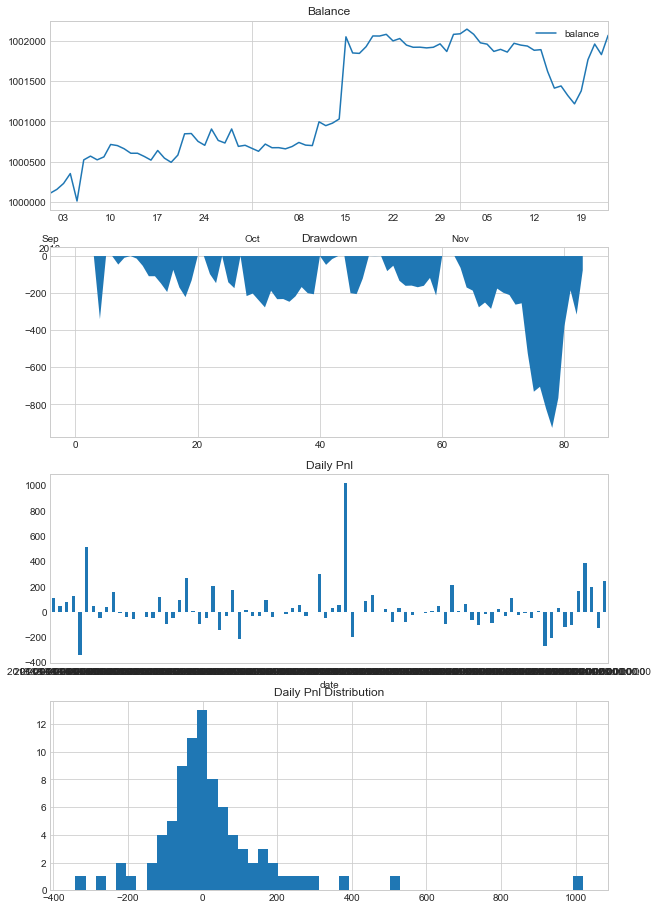

In [5]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-08 23:06:05.818199	计算回测结果
2018-12-08 23:06:05.830206	------------------------------
2018-12-08 23:06:05.830206	第一笔交易：	2018-09-04 16:00:00
2018-12-08 23:06:05.831195	最后一笔交易：	2018-11-23 11:58:00
2018-12-08 23:06:05.831195	总交易次数：	101
2018-12-08 23:06:05.831195	总盈亏：	2,065.86
2018-12-08 23:06:05.831195	最大回撤: 	-1,089.69
2018-12-08 23:06:05.831195	平均每笔盈利：	20.45
2018-12-08 23:06:05.831195	平均每笔滑点：	0.0
2018-12-08 23:06:05.831195	平均每笔佣金：	6.29
2018-12-08 23:06:05.831195	胜率		43.56%
2018-12-08 23:06:05.831195	盈利交易平均值	126.11
2018-12-08 23:06:05.831195	亏损交易平均值	-61.1
2018-12-08 23:06:05.831195	盈亏比：	2.06


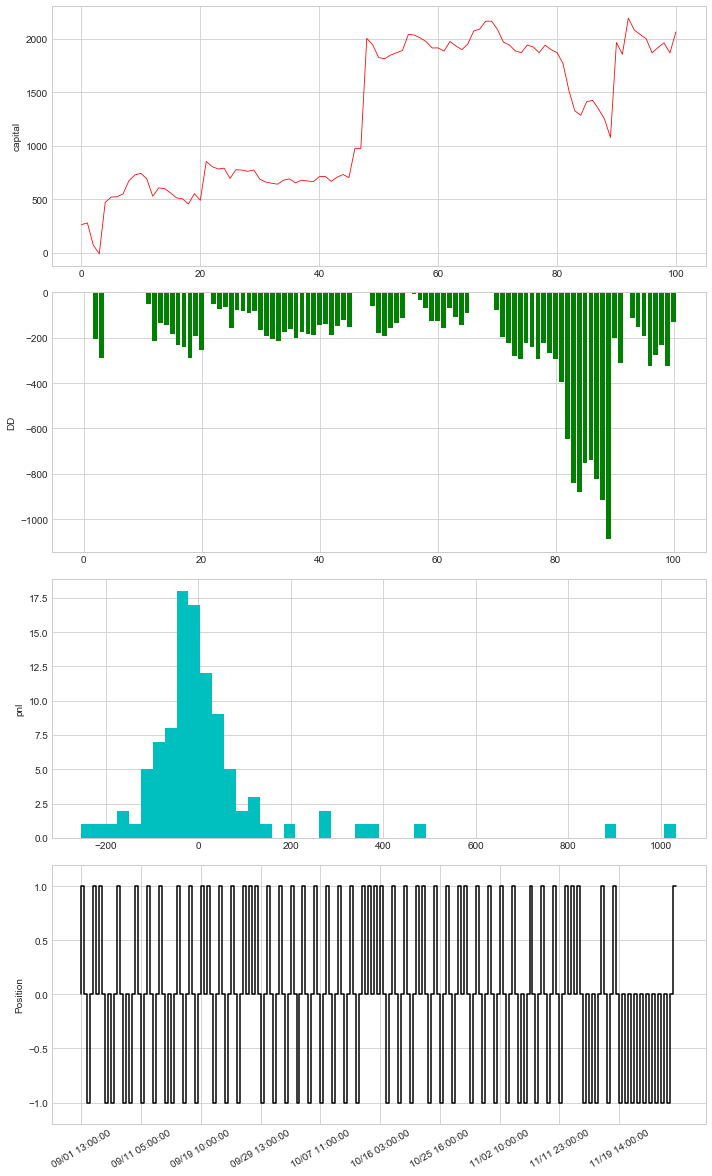

In [6]:
engine.showBacktestingResult()

In [7]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('Ma6wvadPeriod', 5, 15, 1)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('Ma24wvadPeriod', 20, 30, 1)    # 增加第二个优化参数，起始60，结束30，步进10
# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5
setting.addParameter('symbolList', ['BTCUSDT:binance']) 

In [8]:
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MultiFrameWVADStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
#resultList = engine.runParallelOptimization(MultiFrameWVADStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-08 23:06:13.931682	------------------------------
2018-12-08 23:06:13.932682	setting: {'Ma6wvadPeriod': 5, 'Ma24wvadPeriod': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7485CC6A8>, <__main__.MultiFrameWVADStrategy object at 0x000001C7524B33C8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7485CC7B8>, <__main__.MultiFrameWVADStrategy object at 0x000001C7524B33C8>)
2018-12-08 23:06:13.958700	开始回测
2018-12-08 23:06:13.958700	策略初始化
2018-12-08 23:06:13.959701	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:06:14.452029	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:06:14.454030	载入完成，数据量：12000
2018-12-08 23:06:14.455030	策略初始化完成
2018-12-08 23:06:14.455030	策略启动完成
2018-12-08 23:06:14.455030	开始回放回测数据,回测范围:[20180901 12:00,20181123 12

2018-12-08 23:07:12.420237	数据回放结束ss: 100%    
2018-12-08 23:07:12.420237	计算按日统计结果
2018-12-08 23:07:12.489282	------------------------------
2018-12-08 23:07:12.489282	setting: {'Ma6wvadPeriod': 5, 'Ma24wvadPeriod': 23, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549F09D8>, <__main__.MultiFrameWVADStrategy object at 0x000001C751475CC0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7549F0AE8>, <__main__.MultiFrameWVADStrategy object at 0x000001C751475CC0>)
2018-12-08 23:07:12.513298	开始回测
2018-12-08 23:07:12.513298	策略初始化
2018-12-08 23:07:12.514298	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:07:12.987613	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:07:12.990615	载入完成，数据量：12000
2018-12-08 23:07:12.990615	策略初始化完成
2018-12-08 23:07:12.

2018-12-08 23:08:11.009939	数据回放结束ss: 100%    
2018-12-08 23:08:11.009939	计算按日统计结果
2018-12-08 23:08:11.079998	------------------------------
2018-12-08 23:08:11.079998	setting: {'Ma6wvadPeriod': 5, 'Ma24wvadPeriod': 26, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549F08C8>, <__main__.MultiFrameWVADStrategy object at 0x000001C751570C18>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7549F09D8>, <__main__.MultiFrameWVADStrategy object at 0x000001C751570C18>)
2018-12-08 23:08:11.105001	开始回测
2018-12-08 23:08:11.105001	策略初始化
2018-12-08 23:08:11.106003	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:08:11.579291	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:08:11.582293	载入完成，数据量：12000
2018-12-08 23:08:11.582293	策略初始化完成
2018-12-08 23:08:11.

2018-12-08 23:09:08.543411	数据回放结束ss: 100%    
2018-12-08 23:09:08.543411	计算按日统计结果
2018-12-08 23:09:08.613451	------------------------------
2018-12-08 23:09:08.614452	setting: {'Ma6wvadPeriod': 5, 'Ma24wvadPeriod': 29, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D8400>, <__main__.MultiFrameWVADStrategy object at 0x000001C7514C2CF8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7545D8F28>, <__main__.MultiFrameWVADStrategy object at 0x000001C7514C2CF8>)
2018-12-08 23:09:08.637467	开始回测
2018-12-08 23:09:08.637467	策略初始化
2018-12-08 23:09:08.638468	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:09:09.165819	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:09:09.168822	载入完成，数据量：12000
2018-12-08 23:09:09.168822	策略初始化完成
2018-12-08 23:09:09.

2018-12-08 23:10:05.326876	数据回放结束ss: 100%    
2018-12-08 23:10:05.327877	计算按日统计结果
2018-12-08 23:10:05.395921	------------------------------
2018-12-08 23:10:05.395921	setting: {'Ma6wvadPeriod': 6, 'Ma24wvadPeriod': 21, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D8400>, <__main__.MultiFrameWVADStrategy object at 0x000001C750EF6CC0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7545D8F28>, <__main__.MultiFrameWVADStrategy object at 0x000001C750EF6CC0>)
2018-12-08 23:10:05.419938	开始回测
2018-12-08 23:10:05.420938	策略初始化
2018-12-08 23:10:05.421940	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:10:05.906123	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:10:05.909131	载入完成，数据量：12000
2018-12-08 23:10:05.909131	策略初始化完成
2018-12-08 23:10:05.

2018-12-08 23:11:02.076685	数据回放结束ss: 100%    
2018-12-08 23:11:02.076685	计算按日统计结果
2018-12-08 23:11:02.144731	------------------------------
2018-12-08 23:11:02.145732	setting: {'Ma6wvadPeriod': 6, 'Ma24wvadPeriod': 24, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549420D0>, <__main__.MultiFrameWVADStrategy object at 0x000001C751134CC0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942840>, <__main__.MultiFrameWVADStrategy object at 0x000001C751134CC0>)
2018-12-08 23:11:02.169747	开始回测
2018-12-08 23:11:02.169747	策略初始化
2018-12-08 23:11:02.170748	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:11:02.638135	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:11:02.641144	载入完成，数据量：12000
2018-12-08 23:11:02.641144	策略初始化完成
2018-12-08 23:11:02.

2018-12-08 23:11:58.889571	数据回放结束ss: 100%    
2018-12-08 23:11:58.889571	计算按日统计结果
2018-12-08 23:11:58.960618	------------------------------
2018-12-08 23:11:58.960618	setting: {'Ma6wvadPeriod': 6, 'Ma24wvadPeriod': 27, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C754942840>, <__main__.MultiFrameWVADStrategy object at 0x000001C750D34D30>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942620>, <__main__.MultiFrameWVADStrategy object at 0x000001C750D34D30>)
2018-12-08 23:11:58.985634	开始回测
2018-12-08 23:11:58.985634	策略初始化
2018-12-08 23:11:58.986635	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:11:59.451946	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:11:59.454959	载入完成，数据量：12000
2018-12-08 23:11:59.454959	策略初始化完成
2018-12-08 23:11:59.

2018-12-08 23:12:55.578189	数据回放结束ss: 100%    
2018-12-08 23:12:55.578189	计算按日统计结果
2018-12-08 23:12:55.647235	------------------------------
2018-12-08 23:12:55.647235	setting: {'Ma6wvadPeriod': 6, 'Ma24wvadPeriod': 30, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D8158>, <__main__.MultiFrameWVADStrategy object at 0x000001C750B74C18>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7545D81E0>, <__main__.MultiFrameWVADStrategy object at 0x000001C750B74C18>)
2018-12-08 23:12:55.671253	开始回测
2018-12-08 23:12:55.671253	策略初始化
2018-12-08 23:12:55.672252	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:12:56.150590	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:12:56.154604	载入完成，数据量：12000
2018-12-08 23:12:56.154604	策略初始化完成
2018-12-08 23:12:56.

2018-12-08 23:13:52.251077	数据回放结束ss: 100%    
2018-12-08 23:13:52.251077	计算按日统计结果
2018-12-08 23:13:52.321111	------------------------------
2018-12-08 23:13:52.322112	setting: {'Ma6wvadPeriod': 7, 'Ma24wvadPeriod': 22, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D8EA0>, <__main__.MultiFrameWVADStrategy object at 0x000001C7509FCB70>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7545D8488>, <__main__.MultiFrameWVADStrategy object at 0x000001C7509FCB70>)
2018-12-08 23:13:52.347128	开始回测
2018-12-08 23:13:52.347128	策略初始化
2018-12-08 23:13:52.348129	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:13:52.825241	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:13:52.829243	载入完成，数据量：12000
2018-12-08 23:13:52.829243	策略初始化完成
2018-12-08 23:13:52.

2018-12-08 23:14:49.017398	数据回放结束ss: 100%    
2018-12-08 23:14:49.018398	计算按日统计结果
2018-12-08 23:14:49.085442	------------------------------
2018-12-08 23:14:49.086443	setting: {'Ma6wvadPeriod': 7, 'Ma24wvadPeriod': 25, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549420D0>, <__main__.MultiFrameWVADStrategy object at 0x000001C750938F28>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942F28>, <__main__.MultiFrameWVADStrategy object at 0x000001C750938F28>)
2018-12-08 23:14:49.110466	开始回测
2018-12-08 23:14:49.110466	策略初始化
2018-12-08 23:14:49.111460	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:14:49.580713	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:14:49.583714	载入完成，数据量：12000
2018-12-08 23:14:49.583714	策略初始化完成
2018-12-08 23:14:49.

2018-12-08 23:15:45.870275	数据回放结束ss: 100%    
2018-12-08 23:15:45.870275	计算按日统计结果
2018-12-08 23:15:45.939320	------------------------------
2018-12-08 23:15:45.939320	setting: {'Ma6wvadPeriod': 7, 'Ma24wvadPeriod': 28, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D8840>, <__main__.MultiFrameWVADStrategy object at 0x000001C7507F3C88>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7545D8488>, <__main__.MultiFrameWVADStrategy object at 0x000001C7507F3C88>)
2018-12-08 23:15:45.966339	开始回测
2018-12-08 23:15:45.966339	策略初始化
2018-12-08 23:15:45.967339	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:15:46.449681	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:15:46.452663	载入完成，数据量：12000
2018-12-08 23:15:46.453664	策略初始化完成
2018-12-08 23:15:46.

2018-12-08 23:16:42.516061	数据回放结束ss: 100%    
2018-12-08 23:16:42.516061	计算按日统计结果
2018-12-08 23:16:42.584100	------------------------------
2018-12-08 23:16:42.584100	setting: {'Ma6wvadPeriod': 8, 'Ma24wvadPeriod': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D8840>, <__main__.MultiFrameWVADStrategy object at 0x000001C750503CF8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7545D8488>, <__main__.MultiFrameWVADStrategy object at 0x000001C750503CF8>)
2018-12-08 23:16:42.607127	开始回测
2018-12-08 23:16:42.607127	策略初始化
2018-12-08 23:16:42.608128	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:16:43.141487	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:16:43.144488	载入完成，数据量：12000
2018-12-08 23:16:43.145489	策略初始化完成
2018-12-08 23:16:43.

2018-12-08 23:17:39.309148	数据回放结束ss: 100%    
2018-12-08 23:17:39.309148	计算按日统计结果
2018-12-08 23:17:39.377193	------------------------------
2018-12-08 23:17:39.377193	setting: {'Ma6wvadPeriod': 8, 'Ma24wvadPeriod': 23, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D8840>, <__main__.MultiFrameWVADStrategy object at 0x000001C750088D30>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7545D8488>, <__main__.MultiFrameWVADStrategy object at 0x000001C750088D30>)
2018-12-08 23:17:39.400209	开始回测
2018-12-08 23:17:39.400209	策略初始化
2018-12-08 23:17:39.401210	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:17:39.920556	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:17:39.923557	载入完成，数据量：12000
2018-12-08 23:17:39.923557	策略初始化完成
2018-12-08 23:17:39.

2018-12-08 23:18:38.225034	数据回放结束ss: 100%    
2018-12-08 23:18:38.225034	计算按日统计结果
2018-12-08 23:18:38.293080	------------------------------
2018-12-08 23:18:38.294081	setting: {'Ma6wvadPeriod': 8, 'Ma24wvadPeriod': 26, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D8840>, <__main__.MultiFrameWVADStrategy object at 0x000001C74FD79C50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7545D8488>, <__main__.MultiFrameWVADStrategy object at 0x000001C74FD79C50>)
2018-12-08 23:18:38.317095	开始回测
2018-12-08 23:18:38.317095	策略初始化
2018-12-08 23:18:38.318097	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:18:38.776414	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:18:38.779404	载入完成，数据量：12000
2018-12-08 23:18:38.780404	策略初始化完成
2018-12-08 23:18:38.

2018-12-08 23:19:34.987950	数据回放结束ss: 100%    
2018-12-08 23:19:34.987950	计算按日统计结果
2018-12-08 23:19:35.056984	------------------------------
2018-12-08 23:19:35.057985	setting: {'Ma6wvadPeriod': 8, 'Ma24wvadPeriod': 29, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D86A8>, <__main__.MultiFrameWVADStrategy object at 0x000001C74FD3CB00>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7545D8510>, <__main__.MultiFrameWVADStrategy object at 0x000001C74FD3CB00>)
2018-12-08 23:19:35.081000	开始回测
2018-12-08 23:19:35.081000	策略初始化
2018-12-08 23:19:35.082001	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:19:35.556476	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:19:35.560480	载入完成，数据量：12000
2018-12-08 23:19:35.560480	策略初始化完成
2018-12-08 23:19:35.

2018-12-08 23:20:31.791375	数据回放结束ss: 100%    
2018-12-08 23:20:31.792376	计算按日统计结果
2018-12-08 23:20:31.860421	------------------------------
2018-12-08 23:20:31.861422	setting: {'Ma6wvadPeriod': 9, 'Ma24wvadPeriod': 21, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549F0268>, <__main__.MultiFrameWVADStrategy object at 0x000001C74FCCBC88>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7545D86A8>, <__main__.MultiFrameWVADStrategy object at 0x000001C74FCCBC88>)
2018-12-08 23:20:31.883436	开始回测
2018-12-08 23:20:31.883436	策略初始化
2018-12-08 23:20:31.884437	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:20:32.363838	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:20:32.366840	载入完成，数据量：12000
2018-12-08 23:20:32.366840	策略初始化完成
2018-12-08 23:20:32.

2018-12-08 23:21:28.517332	数据回放结束ss: 100%    
2018-12-08 23:21:28.517332	计算按日统计结果
2018-12-08 23:21:28.588380	------------------------------
2018-12-08 23:21:28.588380	setting: {'Ma6wvadPeriod': 9, 'Ma24wvadPeriod': 24, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549F0158>, <__main__.MultiFrameWVADStrategy object at 0x000001C74F50DB00>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7549F0EA0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74F50DB00>)
2018-12-08 23:21:28.611395	开始回测
2018-12-08 23:21:28.611395	策略初始化
2018-12-08 23:21:28.612396	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:21:29.150787	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:21:29.153788	载入完成，数据量：12000
2018-12-08 23:21:29.153788	策略初始化完成
2018-12-08 23:21:29.

2018-12-08 23:22:26.301024	数据回放结束ss: 100%    
2018-12-08 23:22:26.301024	计算按日统计结果
2018-12-08 23:22:26.371070	------------------------------
2018-12-08 23:22:26.371070	setting: {'Ma6wvadPeriod': 9, 'Ma24wvadPeriod': 27, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549F0158>, <__main__.MultiFrameWVADStrategy object at 0x000001C74F03EBA8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7549F0EA0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74F03EBA8>)
2018-12-08 23:22:26.395086	开始回测
2018-12-08 23:22:26.395086	策略初始化
2018-12-08 23:22:26.396087	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:22:26.871536	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:22:26.875551	载入完成，数据量：12000
2018-12-08 23:22:26.875551	策略初始化完成
2018-12-08 23:22:26.

2018-12-08 23:23:23.057979	数据回放结束ss: 100%    
2018-12-08 23:23:23.057979	计算按日统计结果
2018-12-08 23:23:23.129027	------------------------------
2018-12-08 23:23:23.129027	setting: {'Ma6wvadPeriod': 9, 'Ma24wvadPeriod': 30, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549F0158>, <__main__.MultiFrameWVADStrategy object at 0x000001C74F6BCC50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7549F0EA0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74F6BCC50>)
2018-12-08 23:23:23.153042	开始回测
2018-12-08 23:23:23.153042	策略初始化
2018-12-08 23:23:23.154043	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:23:23.642369	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:23:23.645370	载入完成，数据量：12000
2018-12-08 23:23:23.646371	策略初始化完成
2018-12-08 23:23:23.

2018-12-08 23:24:19.583227	数据回放结束ss: 100%    
2018-12-08 23:24:19.583227	计算按日统计结果
2018-12-08 23:24:19.651272	------------------------------
2018-12-08 23:24:19.652273	setting: {'Ma6wvadPeriod': 10, 'Ma24wvadPeriod': 22, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549422F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74ED0BB70>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7549F0C80>, <__main__.MultiFrameWVADStrategy object at 0x000001C74ED0BB70>)
2018-12-08 23:24:19.675289	开始回测
2018-12-08 23:24:19.675289	策略初始化
2018-12-08 23:24:19.676289	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:24:20.157610	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:24:20.160612	载入完成，数据量：12000
2018-12-08 23:24:20.160612	策略初始化完成
2018-12-08 23:24:20

2018-12-08 23:25:16.162652	数据回放结束ss: 100%    
2018-12-08 23:25:16.162652	计算按日统计结果
2018-12-08 23:25:16.233699	------------------------------
2018-12-08 23:25:16.234699	setting: {'Ma6wvadPeriod': 10, 'Ma24wvadPeriod': 25, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549422F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74EBC7C50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7549F08C8>, <__main__.MultiFrameWVADStrategy object at 0x000001C74EBC7C50>)
2018-12-08 23:25:16.255714	开始回测
2018-12-08 23:25:16.255714	策略初始化
2018-12-08 23:25:16.257715	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:25:16.737051	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:25:16.740063	载入完成，数据量：12000
2018-12-08 23:25:16.740063	策略初始化完成
2018-12-08 23:25:16

2018-12-08 23:26:12.936040	数据回放结束ss: 100%    
2018-12-08 23:26:12.937040	计算按日统计结果
2018-12-08 23:26:13.005087	------------------------------
2018-12-08 23:26:13.006088	setting: {'Ma6wvadPeriod': 10, 'Ma24wvadPeriod': 28, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549F02F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74E984C50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C752C33BF8>, <__main__.MultiFrameWVADStrategy object at 0x000001C74E984C50>)
2018-12-08 23:26:13.029103	开始回测
2018-12-08 23:26:13.030103	策略初始化
2018-12-08 23:26:13.031104	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:26:13.495472	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:26:13.498485	载入完成，数据量：12000
2018-12-08 23:26:13.498485	策略初始化完成
2018-12-08 23:26:13

2018-12-08 23:27:09.760678	数据回放结束ss: 100%    
2018-12-08 23:27:09.760678	计算按日统计结果
2018-12-08 23:27:09.828724	------------------------------
2018-12-08 23:27:09.828724	setting: {'Ma6wvadPeriod': 11, 'Ma24wvadPeriod': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549422F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74E580C50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942BF8>, <__main__.MultiFrameWVADStrategy object at 0x000001C74E580C50>)
2018-12-08 23:27:09.852740	开始回测
2018-12-08 23:27:09.852740	策略初始化
2018-12-08 23:27:09.853741	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:27:10.331079	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:27:10.334081	载入完成，数据量：12000
2018-12-08 23:27:10.334081	策略初始化完成
2018-12-08 23:27:10

2018-12-08 23:28:06.375333	数据回放结束ss: 100%    
2018-12-08 23:28:06.375333	计算按日统计结果
2018-12-08 23:28:06.443378	------------------------------
2018-12-08 23:28:06.443378	setting: {'Ma6wvadPeriod': 11, 'Ma24wvadPeriod': 23, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549422F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74E5CFCC0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7549F02F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74E5CFCC0>)
2018-12-08 23:28:06.466393	开始回测
2018-12-08 23:28:06.466393	策略初始化
2018-12-08 23:28:06.467394	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:28:06.927701	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:28:06.930703	载入完成，数据量：12000
2018-12-08 23:28:06.931705	策略初始化完成
2018-12-08 23:28:06

2018-12-08 23:29:03.127009	数据回放结束ss: 100%    
2018-12-08 23:29:03.127009	计算按日统计结果
2018-12-08 23:29:03.195045	------------------------------
2018-12-08 23:29:03.196044	setting: {'Ma6wvadPeriod': 11, 'Ma24wvadPeriod': 26, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C754942BF8>, <__main__.MultiFrameWVADStrategy object at 0x000001C74E207DD8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7549422F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74E207DD8>)
2018-12-08 23:29:03.219060	开始回测
2018-12-08 23:29:03.219060	策略初始化
2018-12-08 23:29:03.220060	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:29:03.702407	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:29:03.705409	载入完成，数据量：12000
2018-12-08 23:29:03.705409	策略初始化完成
2018-12-08 23:29:03

2018-12-08 23:29:59.903322	数据回放结束ss: 100%    
2018-12-08 23:29:59.904323	计算按日统计结果
2018-12-08 23:29:59.973369	------------------------------
2018-12-08 23:29:59.973369	setting: {'Ma6wvadPeriod': 11, 'Ma24wvadPeriod': 29, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C754942598>, <__main__.MultiFrameWVADStrategy object at 0x000001C74E047CF8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942BF8>, <__main__.MultiFrameWVADStrategy object at 0x000001C74E047CF8>)
2018-12-08 23:29:59.998386	开始回测
2018-12-08 23:29:59.998386	策略初始化
2018-12-08 23:29:59.999388	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:30:00.476712	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:30:00.479714	载入完成，数据量：12000
2018-12-08 23:30:00.479714	策略初始化完成
2018-12-08 23:30:00

2018-12-08 23:30:56.577786	数据回放结束ss: 100%    
2018-12-08 23:30:56.577786	计算按日统计结果
2018-12-08 23:30:56.645832	------------------------------
2018-12-08 23:30:56.645832	setting: {'Ma6wvadPeriod': 12, 'Ma24wvadPeriod': 21, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C754942598>, <__main__.MultiFrameWVADStrategy object at 0x000001C74DFCECF8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942BF8>, <__main__.MultiFrameWVADStrategy object at 0x000001C74DFCECF8>)
2018-12-08 23:30:56.669851	开始回测
2018-12-08 23:30:56.669851	策略初始化
2018-12-08 23:30:56.670855	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:30:57.146218	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:30:57.149220	载入完成，数据量：12000
2018-12-08 23:30:57.150221	策略初始化完成
2018-12-08 23:30:57

2018-12-08 23:31:53.542852	数据回放结束ss: 100%    
2018-12-08 23:31:53.543853	计算按日统计结果
2018-12-08 23:31:53.614901	------------------------------
2018-12-08 23:31:53.614901	setting: {'Ma6wvadPeriod': 12, 'Ma24wvadPeriod': 24, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C754942950>, <__main__.MultiFrameWVADStrategy object at 0x000001C74D90FC88>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942598>, <__main__.MultiFrameWVADStrategy object at 0x000001C74D90FC88>)
2018-12-08 23:31:53.636915	开始回测
2018-12-08 23:31:53.636915	策略初始化
2018-12-08 23:31:53.638916	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:31:54.102052	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:31:54.105055	载入完成，数据量：12000
2018-12-08 23:31:54.105055	策略初始化完成
2018-12-08 23:31:54

2018-12-08 23:32:50.345666	数据回放结束ss: 100%    
2018-12-08 23:32:50.345666	计算按日统计结果
2018-12-08 23:32:50.413719	------------------------------
2018-12-08 23:32:50.413719	setting: {'Ma6wvadPeriod': 12, 'Ma24wvadPeriod': 27, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C754942950>, <__main__.MultiFrameWVADStrategy object at 0x000001C74D70ACC0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942598>, <__main__.MultiFrameWVADStrategy object at 0x000001C74D70ACC0>)
2018-12-08 23:32:50.436726	开始回测
2018-12-08 23:32:50.436726	策略初始化
2018-12-08 23:32:50.438727	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:32:50.900046	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:32:50.903037	载入完成，数据量：12000
2018-12-08 23:32:50.904037	策略初始化完成
2018-12-08 23:32:50

2018-12-08 23:33:46.900921	数据回放结束ss: 100%    
2018-12-08 23:33:46.901923	计算按日统计结果
2018-12-08 23:33:46.970963	------------------------------
2018-12-08 23:33:46.970963	setting: {'Ma6wvadPeriod': 12, 'Ma24wvadPeriod': 30, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549422F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74D509CC0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942950>, <__main__.MultiFrameWVADStrategy object at 0x000001C74D509CC0>)
2018-12-08 23:33:46.993972	开始回测
2018-12-08 23:33:46.993972	策略初始化
2018-12-08 23:33:46.995973	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:33:47.463285	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:33:47.466287	载入完成，数据量：12000
2018-12-08 23:33:47.467287	策略初始化完成
2018-12-08 23:33:47

2018-12-08 23:34:43.744362	数据回放结束ss: 100%    
2018-12-08 23:34:43.745363	计算按日统计结果
2018-12-08 23:34:43.812407	------------------------------
2018-12-08 23:34:43.813408	setting: {'Ma6wvadPeriod': 13, 'Ma24wvadPeriod': 22, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7549422F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74DA5BC88>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942950>, <__main__.MultiFrameWVADStrategy object at 0x000001C74DA5BC88>)
2018-12-08 23:34:43.835425	开始回测
2018-12-08 23:34:43.835425	策略初始化
2018-12-08 23:34:43.837424	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:34:44.307767	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:34:44.310775	载入完成，数据量：12000
2018-12-08 23:34:44.310775	策略初始化完成
2018-12-08 23:34:44

2018-12-08 23:35:40.332354	数据回放结束ss: 100%    
2018-12-08 23:35:40.332354	计算按日统计结果
2018-12-08 23:35:40.399399	------------------------------
2018-12-08 23:35:40.400400	setting: {'Ma6wvadPeriod': 13, 'Ma24wvadPeriod': 25, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C748784C80>, <__main__.MultiFrameWVADStrategy object at 0x000001C74CC99B38>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7549422F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74CC99B38>)
2018-12-08 23:35:40.423415	开始回测
2018-12-08 23:35:40.423415	策略初始化
2018-12-08 23:35:40.424416	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:35:40.906623	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:35:40.909616	载入完成，数据量：12000
2018-12-08 23:35:40.909616	策略初始化完成
2018-12-08 23:35:40

2018-12-08 23:36:36.947105	数据回放结束ss: 100%    
2018-12-08 23:36:36.947105	计算按日统计结果
2018-12-08 23:36:37.019148	------------------------------
2018-12-08 23:36:37.019148	setting: {'Ma6wvadPeriod': 13, 'Ma24wvadPeriod': 28, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C748784C80>, <__main__.MultiFrameWVADStrategy object at 0x000001C74CA4DCC0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C754942598>, <__main__.MultiFrameWVADStrategy object at 0x000001C74CA4DCC0>)
2018-12-08 23:36:37.043157	开始回测
2018-12-08 23:36:37.043157	策略初始化
2018-12-08 23:36:37.044167	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:36:37.513476	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:36:37.517485	载入完成，数据量：12000
2018-12-08 23:36:37.517485	策略初始化完成
2018-12-08 23:36:37

2018-12-08 23:37:33.621468	数据回放结束ss: 100%    
2018-12-08 23:37:33.621468	计算按日统计结果
2018-12-08 23:37:33.689526	------------------------------
2018-12-08 23:37:33.689526	setting: {'Ma6wvadPeriod': 14, 'Ma24wvadPeriod': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D80D0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74CC1DCF8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C748784C80>, <__main__.MultiFrameWVADStrategy object at 0x000001C74CC1DCF8>)
2018-12-08 23:37:33.711529	开始回测
2018-12-08 23:37:33.711529	策略初始化
2018-12-08 23:37:33.713530	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:37:34.242967	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:37:34.245969	载入完成，数据量：12000
2018-12-08 23:37:34.245969	策略初始化完成
2018-12-08 23:37:34

2018-12-08 23:38:30.204108	数据回放结束ss: 100%    
2018-12-08 23:38:30.204108	计算按日统计结果
2018-12-08 23:38:30.271152	------------------------------
2018-12-08 23:38:30.271152	setting: {'Ma6wvadPeriod': 14, 'Ma24wvadPeriod': 23, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7545D80D0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74CA1FCF8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C748784C80>, <__main__.MultiFrameWVADStrategy object at 0x000001C74CA1FCF8>)
2018-12-08 23:38:30.294168	开始回测
2018-12-08 23:38:30.294168	策略初始化
2018-12-08 23:38:30.295168	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:38:30.825543	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:38:30.828551	载入完成，数据量：12000
2018-12-08 23:38:30.828551	策略初始化完成
2018-12-08 23:38:30

2018-12-08 23:39:26.852775	数据回放结束ss: 100%    
2018-12-08 23:39:26.852775	计算按日统计结果
2018-12-08 23:39:26.921821	------------------------------
2018-12-08 23:39:26.921821	setting: {'Ma6wvadPeriod': 14, 'Ma24wvadPeriod': 26, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C752C33E18>, <__main__.MultiFrameWVADStrategy object at 0x000001C74C21DC50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C752CF4730>, <__main__.MultiFrameWVADStrategy object at 0x000001C74C21DC50>)
2018-12-08 23:39:26.943835	开始回测
2018-12-08 23:39:26.943835	策略初始化
2018-12-08 23:39:26.944838	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:39:27.469202	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:39:27.472217	载入完成，数据量：12000
2018-12-08 23:39:27.472217	策略初始化完成
2018-12-08 23:39:27

2018-12-08 23:40:23.481716	数据回放结束ss: 100%    
2018-12-08 23:40:23.481716	计算按日统计结果
2018-12-08 23:40:23.553768	------------------------------
2018-12-08 23:40:23.553768	setting: {'Ma6wvadPeriod': 14, 'Ma24wvadPeriod': 29, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7485B2EA0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74BE51A58>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C752C33E18>, <__main__.MultiFrameWVADStrategy object at 0x000001C74BE51A58>)
2018-12-08 23:40:23.575777	开始回测
2018-12-08 23:40:23.575777	策略初始化
2018-12-08 23:40:23.576778	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:40:24.038085	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:40:24.041087	载入完成，数据量：12000
2018-12-08 23:40:24.041087	策略初始化完成
2018-12-08 23:40:24

2018-12-08 23:41:20.361486	数据回放结束ss: 100%    
2018-12-08 23:41:20.361486	计算按日统计结果
2018-12-08 23:41:20.428538	------------------------------
2018-12-08 23:41:20.429531	setting: {'Ma6wvadPeriod': 15, 'Ma24wvadPeriod': 21, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C7531DCD90>, <__main__.MultiFrameWVADStrategy object at 0x000001C74B957BA8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C7531DC268>, <__main__.MultiFrameWVADStrategy object at 0x000001C74B957BA8>)
2018-12-08 23:41:20.451547	开始回测
2018-12-08 23:41:20.451547	策略初始化
2018-12-08 23:41:20.452547	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:41:20.921861	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:41:20.924863	载入完成，数据量：12000
2018-12-08 23:41:20.924863	策略初始化完成
2018-12-08 23:41:20

2018-12-08 23:42:16.896764	数据回放结束ss: 100%    
2018-12-08 23:42:16.896764	计算按日统计结果
2018-12-08 23:42:16.965809	------------------------------
2018-12-08 23:42:16.966812	setting: {'Ma6wvadPeriod': 15, 'Ma24wvadPeriod': 24, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C752C33F28>, <__main__.MultiFrameWVADStrategy object at 0x000001C74B654BA8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C752C331E0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74B654BA8>)
2018-12-08 23:42:16.988825	开始回测
2018-12-08 23:42:16.988825	策略初始化
2018-12-08 23:42:16.989827	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:42:17.452135	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:42:17.455144	载入完成，数据量：12000
2018-12-08 23:42:17.456143	策略初始化完成
2018-12-08 23:42:17

2018-12-08 23:43:13.428203	数据回放结束ss: 100%    
2018-12-08 23:43:13.428203	计算按日统计结果
2018-12-08 23:43:13.496260	------------------------------
2018-12-08 23:43:13.497249	setting: {'Ma6wvadPeriod': 15, 'Ma24wvadPeriod': 27, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C754942BF8>, <__main__.MultiFrameWVADStrategy object at 0x000001C74B965B38>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C752C332F0>, <__main__.MultiFrameWVADStrategy object at 0x000001C74B965B38>)
2018-12-08 23:43:13.519263	开始回测
2018-12-08 23:43:13.519263	策略初始化
2018-12-08 23:43:13.520265	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:43:14.040625	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:43:14.043626	载入完成，数据量：12000
2018-12-08 23:43:14.043626	策略初始化完成
2018-12-08 23:43:14

2018-12-08 23:44:10.173842	数据回放结束ss: 100%    
2018-12-08 23:44:10.173842	计算按日统计结果
2018-12-08 23:44:10.240887	------------------------------
2018-12-08 23:44:10.240887	setting: {'Ma6wvadPeriod': 15, 'Ma24wvadPeriod': 30, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameWVADStrategy.on60MinBar at 0x000001C754942BF8>, <__main__.MultiFrameWVADStrategy object at 0x000001C74B4D8CC0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameWVADStrategy.onBar at 0x000001C752C33D90>, <__main__.MultiFrameWVADStrategy object at 0x000001C74B4D8CC0>)
2018-12-08 23:44:10.263901	开始回测
2018-12-08 23:44:10.263901	策略初始化
2018-12-08 23:44:10.264903	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-08 23:44:10.722214	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 23:44:10.725209	载入完成，数据量：12000
2018-12-08 23:44:10.726210	策略初始化完成
2018-12-08 23:44:10

In [9]:
import pandas as pd
print(pd.DataFrame(resultList).sort_values(1, ascending=False))

                                                     0         1  \
0    [{'Ma6wvadPeriod': 12, 'Ma24wvadPeriod': 28, '...  4.659635   
1    [{'Ma6wvadPeriod': 10, 'Ma24wvadPeriod': 22, '...  4.651760   
2    [{'Ma6wvadPeriod': 13, 'Ma24wvadPeriod': 28, '...  4.643429   
3    [{'Ma6wvadPeriod': 9, 'Ma24wvadPeriod': 22, 's...  4.630740   
4    [{'Ma6wvadPeriod': 14, 'Ma24wvadPeriod': 28, '...  4.628695   
5    [{'Ma6wvadPeriod': 14, 'Ma24wvadPeriod': 29, '...  4.621974   
6    [{'Ma6wvadPeriod': 13, 'Ma24wvadPeriod': 27, '...  4.598061   
7    [{'Ma6wvadPeriod': 12, 'Ma24wvadPeriod': 26, '...  4.596566   
8    [{'Ma6wvadPeriod': 15, 'Ma24wvadPeriod': 27, '...  4.579045   
9    [{'Ma6wvadPeriod': 14, 'Ma24wvadPeriod': 27, '...  4.552821   
10   [{'Ma6wvadPeriod': 15, 'Ma24wvadPeriod': 26, '...  4.549384   
11   [{'Ma6wvadPeriod': 15, 'Ma24wvadPeriod': 28, '...  4.528334   
12   [{'Ma6wvadPeriod': 14, 'Ma24wvadPeriod': 21, '...  4.520370   
13   [{'Ma6wvadPeriod': 9, 'Ma24wvadPeriod': 23,

In [10]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))

------------------------------
参数：["{'Ma6wvadPeriod': 12, 'Ma24wvadPeriod': 28, 'symbolList': ['BTCUSDT:binance']}"]，目标：4.65963523294
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profitDays：49
lossDays：34
endBalance：1002335.38175
maxDrawdown：-774.995505
maxDdPercent：-0.0777374983464
totalNetPnl：2335.381745000006
dailyNetPnl：27.802163630952453
totalCommission：640.8122550000002
dailyCommission：7.6287173214285735
totalSlippage：0.40600000000000025
dailySlippage：0.004833333333333336
totalTurnover：1281624.5099999995
dailyTurnover：15257.434642857137
totalTradeCount：203
dailyTradeCount：2.4166666666666665
totalReturn：0.2335381745
annualizedReturn：0.667251927143
dailyReturn：0.009436159144405295
returnStd：0.0313724876660484
sharpeRatio：4.65963523294
------------------------------
参数：["{'Ma6wvadPeriod': 10, 'Ma24wvadPeriod': 22, 'symbolList': ['BTCUSDT:binance']}"]，目标：4.65176039542
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profitDa

maxDdPercent：-0.0817652187393
totalNetPnl：1913.096940000006
dailyNetPnl：22.774963571428643
totalCommission：664.7310600000003
dailyCommission：7.913465000000004
totalSlippage：0.42200000000000026
dailySlippage：0.005023809523809527
totalTurnover：1329462.1199999996
dailyTurnover：15826.929999999997
totalTradeCount：211
dailyTradeCount：2.511904761904762
totalReturn：0.191309694
annualizedReturn：0.546599125714
dailyReturn：0.008934504764982318
returnStd：0.03202511957496328
sharpeRatio：4.32200580302
------------------------------
参数：["{'Ma6wvadPeriod': 8, 'Ma24wvadPeriod': 22, 'symbolList': ['BTCUSDT:binance']}"]，目标：4.31830518392
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profitDays：45
lossDays：38
endBalance：1001980.00713
maxDrawdown：-730.68099
maxDdPercent：-0.0733002085788
totalNetPnl：1980.0071350000048
dailyNetPnl：23.57151351190482
totalCommission：659.1748650000005
dailyCommission：7.847319821428577
totalSlippage：0.41800000000000026
dailySlippage：0.00497619047619

startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profitDays：45
lossDays：37
endBalance：1001440.03309
maxDrawdown：-945.83786
maxDdPercent：-0.0944120286272
totalNetPnl：1440.0330900000051
dailyNetPnl：17.143251071428633
totalCommission：638.71091
dailyCommission：7.603701309523809
totalSlippage：0.4060000000000003
dailySlippage：0.004833333333333337
totalTurnover：1277421.8199999996
dailyTurnover：15207.402619047614
totalTradeCount：203
dailyTradeCount：2.4166666666666665
totalReturn：0.144003309
annualizedReturn：0.411438025714
dailyReturn：0.0015833597436541525
returnStd：0.01651013402212948
sharpeRatio：1.48571196576
------------------------------
参数：["{'Ma6wvadPeriod': 6, 'Ma24wvadPeriod': 21, 'symbolList': ['BTCUSDT:binance']}"]，目标：1.41505236648
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profitDays：41
lossDays：41
endBalance：1001471.66285
maxDrawdown：-853.742785
maxDdPercent：-0.0852287259957
totalNetPnl：1471.662849999998
dailyNetPnl：17.51979583